In [1]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4, suppress=True, linewidth=120)

,time,ind_fact,ind_x,seg_fact_0,seg_x_0,seg_fact_1,seg_x_1,seg_fact_2,seg_x_2,sub_fact_0,...,y_2_0,y_2_1,y_2_2,y_2_3,y_2_4,y_2_5,y_2_6,y_2_7,y_2_8,y_2_9
0,2006-01-01,0.617965,0.654700,0.878927,-0.083134,1.015221,-0.218856,-0.855864,0.223779,0.556707,...,-1.280638,0.499409,-0.444924,0.114704,2.138596,-0.053347,0.015183,0.923343,1.223400,-0.375277
1,2006-02-01,0.834329,0.525347,1.148808,0.533560,-0.607089,-1.317744,-0.406252,0.192853,1.730982,...,-0.354040,1.085192,1.637612,1.276285,-0.709482,1.651665,0.497446,1.736326,0.071178,-0.154247
2,2006-03-01,-0.619074,-1.036238,1.976687,1.172521,-1.273225,-0.848262,0.962789,1.247165,-0.549872,...,0.583361,2.170522,-0.466098,-0.814738,0.941311,0.784818,-0.758978,-0.017826,-0.758957,0.999186
3,2006-04-01,-0.951931,-0.642394,1.395388,0.011708,-0.829368,0.061890,0.224309,-0.449644,-1.857124,...,-0.907656,-1.689583,-1.130755,-2.571953,0.443879,0.023989,-1.197288,-0.077298,-1.450812,-2.897065
4,2006-05-01,-0.622445,-0.146479,1.888457,0.911685,-0.499975,0.080583,-0.169696,-0.326712,-0.385985,...,0.305881,-1.343165,-0.521349,-1.328999,-0.926203,-1.172047,0.038210,0.013085,-1.243235,-0.632701


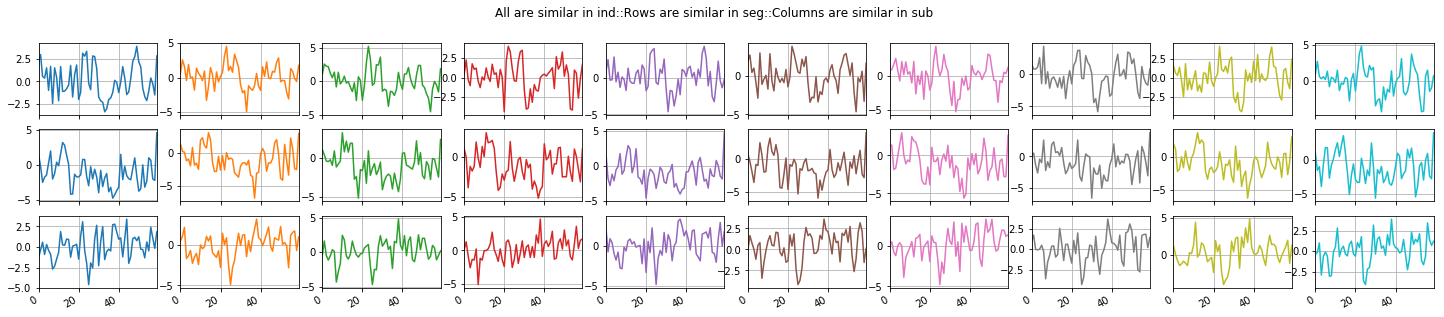

In [3]:
###simulate time series data 
periods=500
seed=98165
# factor_model=pd.DataFrame(pd.date_range(start='1/1/2018', end='2/1/2019', freq='M', normalize=True),columns=['time']).astype('datetime64[M]')

factor_model=pd.DataFrame(pd.date_range(start='1/1/2006', periods=periods, freq='M', normalize=True),columns=['time']).astype('datetime64[M]')

np.random.seed(seed)

def factor_gen(size=periods, beta=0.8, burner=2, scale=1):
    j=burner+size
    x=np.random.normal(loc=0.0, scale=scale, size=j)
    
    y=[0]*j
    for i in range(j):
        
        if i==0:
            y0=0 
        else:
            y[i]=beta*y0 + x[i]
            y0=y[i]
            
    return y[-size:], x[-size:]

###industry factor
fact_name='ind_fact'
fact_name_x='ind_x'
fact, fact_x = factor_gen(size=periods, beta=0.5, burner=200)
factor_model[fact_name]=fact 
factor_model[fact_name_x]=fact_x 

###segment factor
seg=3
sub=10
for i in range(seg):
    fact_name='seg_fact_'+str(i)
    fact_name_x='seg_x_'+str(i)
    fact, fact_x = factor_gen(size=periods, beta=0.7, burner=200)
    factor_model[fact_name]=fact 
    factor_model[fact_name_x]=fact_x 

###brand factor
for i in range(sub):
    fact_name='sub_fact_'+str(i)
    fact_name_x='sub_x_'+str(i)
    fact, fact_x = factor_gen(size=periods, beta=0.3, burner=200)
    factor_model[fact_name]=fact 
    factor_model[fact_name_x]=fact_x 
    
###idiosyncratic factor
for s in range(seg):
    for b in range(sub):
        fact_name='idi_fact_' + str(s) + '_' + str(b)
        fact_name_x='idi_fact_x' + str(s) + '_' + str(b)
        fact, fact_x = factor_gen(size=periods, beta=0.0, burner=200, scale=1)
        factor_model[fact_name]=fact
        factor_model[fact_name_x]=fact_x

# factor_model['x1']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))
# factor_model['x2']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))  
# factor_model['x3']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods)) 
# factor_model['x4']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods)) 
# factor_model['x5']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods)) 
# factor_model['x6']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))
# factor_model['x7']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))
# factor_model['x8']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods)) 
# factor_model['x9']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))
# factor_model['x10']=pd.DataFrame(np.random.normal(loc=0.0, scale=1, size=periods))


        
###observed y --output

for s in range(seg):
    for b in range(sub):
        fact_name='y_' + str(s) + '_' + str(b)
        seg_fact='seg_fact_' + str(s)
        sub_fact='sub_fact_' + str(b)
        idi_fact= 'idi_fact_' + str(s) + '_' + str(b)
#         factor_model[fact_name]=factor_model['ind_fact']+factor_model[seg_fact] + factor_model[sub_fact] + factor_model[idi_fact]
        factor_model[fact_name]=factor_model['ind_fact'] + factor_model[seg_fact] +  factor_model[idi_fact] 
#         factor_model[fact_name]=factor_model['ind_fact']  + factor_model[idi_fact] + 0.2*factor_model['x1'] -  0.2*factor_model['x2'] \
#         + 0.2*factor_model['x3'] -  0.2*factor_model['x4'] + 0.2*factor_model['x5'] -  0.2*factor_model['x6'] \
#         + 0.2*factor_model['x7'] -  0.2*factor_model['x8'] + 0.2*factor_model['x9'] -  0.2*factor_model['x10'] 
        factor_model[fact_name_x]=fact_x
    
# print(factor_model.columns)
_=factor_model[[name for name in factor_model.columns if 'y_' in name]][(
    factor_model.time.dt.year<=2010)].plot(subplots=True, layout=( seg,sub), figsize=(25, 5), grid=True, legend=False, 
                                           title='All are similar in ind::Rows are similar in seg::Columns are similar in sub')
factor_model.head(5)

In [4]:
# call existing package
var_list=[name for name in factor_model.columns if 'y_' in name]
endog=factor_model[var_list]
# exog=factor_model[['x1','x2']]
# [name for name in factor_model.columns if 'y_' in name]
import time

In [6]:
numl=[]
for char in var_list: #set the first column as ones for f_seg
    num = [int(i) for i in char.split('_') if i.isdigit()]
    numl.append(num)

seg_bnd=[ ['seg_'+str(numl[ivar][0]).zfill(3),'bnd_'+str(numl[ivar][1]).zfill(3)]  for ivar in range(len(var_list))]

factors={var_list[ivar] :  ['Global',seg_bnd[ivar][0] ] for ivar in range(len(var_list))} # ,seg_bnd[ivar][0], seg_bnd[ivar][1]
# factors

In [7]:
# factors
factor_multiplicities={'Global': 1}

In [8]:
# Construct the dynamic factor model
model = sm.tsa.DynamicFactorMQ(
    endog=endog,
    factors=factors, factor_orders=1,
    factor_multiplicities=1,  idiosyncratic_ar1=False) # idiosyncratic_ar1=False which means NO AR(1) fitting. Error AR(1) is default So far no AR(2)+ are avaliable.
model.summary()
ts=time.time()
results_MQ = model.fit(disp=10)
print(time.time()-ts)
results_MQ.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                         
===========================================================================================
Model:                Dynamic Factor Model   # of observed variables:                    30
                   + 4 factors in 4 blocks   # of factor blocks:                          4
                       + iid idiosyncratic   Idiosyncratic disturbances:                iid
Sample:                                  0   Standardize variables:                    True
                                     - 500                                                 
           Observed variables / factor loadings           
==========================================================
Dep. variable     Global    seg_000    seg_001     seg_002
----------------------------------------------------------
        y_0_0       X          X                          
        y_0_1       X          X                          
        y_0_2       X          X                          
        y_0_3       X          X                          
        y_0_4       X          X                          
        y_0_5       X          X                          
        y_0_6       X          X                          
        y_0_7       X          X                          
        y_0_8       X          X                          
        y_0_9       X          X                          
        y_1_0       X                     X               
        y_1_1       X                     X               
        y_1_2       X                     X               
        y_1_3       X                     X               
        y_1_4       X                     X               
        y_1_5       X                     X               
        y_1_6       X                     X               
        y_1_7       X                     X               
        y_1_8       X                     X               
        y_1_9       X                     X               
        y_2_0       X                                 X   
        y_2_1       X                                 X   
        y_2_2       X                                 X   
        y_2_3       X                                 X   
        y_2_4       X                                 X   
        y_2_5       X                                 X   
        y_2_6       X                                 X   
        y_2_7       X                                 X   
        y_2_8       X                                 X   
        y_2_9       X                                 X   
    Factor blocks:   
=====================
     block      order
---------------------
    Global          1
   seg_000          1
   seg_001          1
   seg_002          1
=====================
"""

EM start iterations, llf=-13845
EM iteration 10, llf=-13290, convergence criterion=6.9304e-06
EM iteration 20, llf=-13290, convergence criterion=1.6996e-06
EM converged at iteration 26, llf=-13290, convergence criterion=9.7184e-07 < tolerance=1e-06
1.2228593826293945


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Dynamic Factor Results                              
===================================================================================
Dep. Variable:        "y_0_0", and 29 more   No. Observations:                  500
Model:                Dynamic Factor Model   Log Likelihood              -13289.799
                   + 4 factors in 4 blocks   AIC                          26775.598
                       + iid idiosyncratic   BIC                          27188.629
Date:                     Sat, 30 Jan 2021   HQIC                         26937.670
Time:                             14:10:07   EM Iterations                       26
Sample:                                  0                                         
                                     - 500                                         
Covariance Type:              Not computed                                         
                          Observation equation:                          
=========================================================================
Factor loadings:     Global    seg_000    seg_001     seg_002        var.
-------------------------------------------------------------------------
           y_0_0      -0.19       0.21          .           .        0.22
           y_0_1      -0.18       0.22          .           .        0.24
           y_0_2      -0.17       0.23          .           .        0.21
           y_0_3      -0.20       0.20          .           .        0.24
           y_0_4      -0.19       0.21          .           .        0.27
           y_0_5      -0.19       0.21          .           .        0.23
           y_0_6      -0.18       0.22          .           .        0.22
           y_0_7      -0.19       0.21          .           .        0.24
           y_0_8      -0.17       0.22          .           .        0.27
           y_0_9      -0.18       0.22          .           .        0.23
           y_1_0      -0.17          .       0.23           .        0.26
           y_1_1      -0.17          .       0.23           .        0.26
           y_1_2      -0.17          .       0.24           .        0.23
           y_1_3      -0.16          .       0.24           .        0.25
           y_1_4      -0.17          .       0.22           .        0.30
           y_1_5      -0.17          .       0.23           .        0.25
           y_1_6      -0.15          .       0.24           .        0.29
           y_1_7      -0.18          .       0.23           .        0.27
           y_1_8      -0.17          .       0.24           .        0.26
           y_1_9      -0.16          .       0.24           .        0.25
           y_2_0      -0.18          .          .        0.23        0.28
           y_2_1      -0.18          .          .        0.24        0.26
           y_2_2      -0.18          .          .        0.23        0.29
           y_2_3      -0.18          .          .        0.23        0.27
           y_2_4      -0.16          .          .        0.25        0.24
           y_2_5      -0.17          .          .        0.24        0.30
           y_2_6      -0.19          .          .        0.22        0.30
           y_2_7      -0.19          .          .        0.22        0.29
           y_2_8      -0.18          .          .        0.24        0.28
           y_2_9      -0.18          .          .        0.22        0.31
       Transition: Factor block 0      
=======================================
            L1.Global    error variance
---------------------------------------
    Global       0.37              8.04
       Transition: Factor block 1      
=======================================
           L1.seg_000    error variance
---------------------------------------
   seg_000       0.70              4.92
       Transition: Factor block 2      
=======================================
           L1.seg_001    error v

In [9]:
params=pd.DataFrame(results_MQ.params, columns=[ 'Estimates'])
params.to_csv(r'c:\temp\params_DynamicFactorMQ_one_factor.csv')
params_loading=params['loading.Global->y_0_0':'loading.Global->y_2_9']
params_obs_cov=params['sigma2.y_0_0':'sigma2.y_2_9']
params_state_cov=params['fb(0).cov.chol[1,1]':'fb(0).cov.chol[1,1]']
params_transition=params['L1.Global->Global':'L1.Global->Global']
print('----> Total Parameters in MQ: ', results_MQ.params.size)

----> Total Parameters in MQ:  98


In [9]:
###sm.tsa.statespace.MLEModel 1) standards

In [10]:
# var_list=[name for name in factor_model.columns if 'y_' in name]
# endog=factor_model[var_list]
# var_list

In [11]:
f_ind=1
f_seg=3
f_sub=0

k_factors=f_ind + f_seg + f_sub
fix_obs_cov=False

endog.columns

#######generate matrix below########
design = np.zeros((len(endog.columns), k_factors))

design[:,0]=1   #set the first column as ones for ind_factor
n=0
for char in endog.columns: #set the first column as ones for f_seg
    numl = [int(i) for i in char.split('_') if i.isdigit()]
    num=numl[0]
    design[n, num+1] = 1
    n+=1

# n=0
# for char in endog.columns: #set the first column as ones for f_seg
#     numl = [int(i) for i in char.split('_') if i.isdigit()]
#     num=numl[1]
#     design[n, f_seg+num+1] = 1
#     n+=1
    
# design

Index(['y_0_0', 'y_0_1', 'y_0_2', 'y_0_3', 'y_0_4', 'y_0_5', 'y_0_6', 'y_0_7',
       'y_0_8', 'y_0_9', 'y_1_0', 'y_1_1', 'y_1_2', 'y_1_3', 'y_1_4', 'y_1_5',
       'y_1_6', 'y_1_7', 'y_1_8', 'y_1_9', 'y_2_0', 'y_2_1', 'y_2_2', 'y_2_3',
       'y_2_4', 'y_2_5', 'y_2_6', 'y_2_7', 'y_2_8', 'y_2_9'],
      dtype='object')

In [12]:
print('initials: --paste to the following cell')    
print("self['transition'] = np.eye(", k_factors , ")") 
print("self['selection'] = np.eye(",  k_factors , ")") 
print("self['state_cov'] = np.eye(",  k_factors , ")") 
print("self['obs_cov'] = np.eye(", len(endog.columns) , ")")  

n=0
param_list=[]
update_list=[]
for i_c in range(k_factors):
    for j_r in range(len(endog.columns)):
        if design[j_r, i_c]==1.0:
            name='load_'+str(i_c)+'_'+str(j_r)
            param_list.append(name) 
            update_str = "self['design'" + ',' + str(j_r) + ',' + str(i_c) + "] = params[" +str(n) + "]"
            update_list.append(update_str)
            n+=1
           
for i in range(k_factors):
    name='f_ar_'+str(i)
    param_list.append(name) 
    update_str = "self['transition'" + ',' + str(i) + ',' + str(i) + "] = params[" +str(n) + "]"
    update_list.append(update_str)
    n+=1

if fix_obs_cov==False:
    for i in range(len(endog.columns)):
        name='err_var_'+str(i)
        param_list.append(name) 
        update_str = "self['obs_cov'" + ',' + str(i) + ',' + str(i) + "] = params[" +str(n) + "]"
        update_list.append(update_str)
        n+=1

update_statement=(';').join(update_list)       
print();print();print()
# print('parameter names:')
# param_list
print();print();print()
print('updates: --paste to the following cell')
# update_list
update_statement
# update_list

initials: --paste to the following cell
self['transition'] = np.eye( 4 )
self['selection'] = np.eye( 4 )
self['state_cov'] = np.eye( 4 )
self['obs_cov'] = np.eye( 30 )






updates: --paste to the following cell


"self['design',0,0] = params[0];self['design',1,0] = params[1];self['design',2,0] = params[2];self['design',3,0] = params[3];self['design',4,0] = params[4];self['design',5,0] = params[5];self['design',6,0] = params[6];self['design',7,0] = params[7];self['design',8,0] = params[8];self['design',9,0] = params[9];self['design',10,0] = params[10];self['design',11,0] = params[11];self['design',12,0] = params[12];self['design',13,0] = params[13];self['design',14,0] = params[14];self['design',15,0] = params[15];self['design',16,0] = params[16];self['design',17,0] = params[17];self['design',18,0] = params[18];self['design',19,0] = params[19];self['design',20,0] = params[20];self['design',21,0] = params[21];self['design',22,0] = params[22];self['design',23,0] = params[23];self['design',24,0] = params[24];self['design',25,0] = params[25];self['design',26,0] = params[26];self['design',27,0] = params[27];self['design',28,0] = params[28];self['design',29,0] = params[29];self['design',0,1] = params[3

In [14]:
class Three_factor(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):
        # Initialize the state space model
        super(Three_factor, self).__init__(endog, k_factors=4,  k_states=4, factor_order=1, 
                                  initialization='stationary')
#         k_factors=1, factor_order=1, error_order=1

        # Setup the fixed components of the state space representation
        self['transition'] = np.eye( 4 )
        self['selection'] = np.eye( 4 )
        self['state_cov'] = np.eye( 4 )
        self['obs_cov'] = np.eye( 30 )


    # Describe how parameters enter the model
    def update(self, params, transformed=True, **kwargs):
        params = super(Three_factor, self).update(params, transformed, **kwargs)
        exec(update_statement)
        
    @property
    def param_names(self):
        return param_list

    # Specify start parameters and parameter names
    @property
    def start_params(self):
        return [0.1]*(93+1)
    
ts=time.time()
model = Three_factor(endog)
results_ML = model.fit(disp=True, maxiter=5000)
print(time.time()-ts)
results_ML.summary()

print('----> Total Parameters in ML: ', results_ML.params.size)

19.666156768798828


<class 'statsmodels.iolib.summary.Summary'>
"""
                                                                                                                                                         Statespace Model Results                                                                                                                                                         
==========================================================================================================================================================================================================================================================================================================================================
Dep. Variable:     ['y_0_0', 'y_0_1', 'y_0_2', 'y_0_3', 'y_0_4', 'y_0_5', 'y_0_6', 'y_0_7', 'y_0_8', 'y_0_9', 'y_1_0', 'y_1_1', 'y_1_2', 'y_1_3', 'y_1_4', 'y_1_5', 'y_1_6', 'y_1_7', 'y_1_8', 'y_1_9', 'y_2_0', 'y_2_1', 'y_2_2', 'y_2_3', 'y_2_4', 'y_2_5', 'y_2_6', 'y_2_7', 'y_2_8', 'y_2_9']   No. Observations:                  500
Model:                                                                                                                                                                                                                                                                               Three_factor   Log Likelihood              -23365.916
Date:                                                                                                                                                                                                                                                                            Sat, 30 Jan 2021   AIC                          46919.833
Time:                                                                                                                                                                                                                                                                                    14:12:52   BIC                          47316.006
Sample:                                                                                                                                                                                                                                                                                         0   HQIC                         47075.290
                                                                                                                                                                                                                                                                                            - 500                                         
Covariance Type:                                                                                                                                                                                                                                                                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
load_0_0       1.0732      0.099     10.868      0.000       0.880       1.267
load_0_1       1.0328      0.096     10.776      0.000       0.845       1.221
load_0_2       0.9535      0.095     10.053      0.000       0.768       1.139
load_0_3       1.1264      0.097     11.586      0.000       0.936       1.317
load_0_4       1.0003      0.095     10.488      0.000       0.813       1.187
load_0_5       1.0552      0.097     10.838      0.000       0.864       1.246
load_0_6       1.0604      0.100     10.626      0.000       0.865       1.256
load_0_7       1.1045      0.102     10.779      0.000       0.904       1.305
load_0_8       0.9441      0.108      8.743      0.000       0.732       1.156
load_0_9       1.0385    

----> Total Parameters in ML:  94


In [46]:
##the diiference in first several observation is larger. 

df_all=pd.concat([pd.DataFrame(results_ML.smoothed_state.T, columns=[ 'smoothed_state_ML'+str(i) for i in range(results_ML.smoothed_state.shape[0])])
,pd.DataFrame(results_MQ.smoothed_state.T, columns=[ 'smoothed_state_MQ'+str(i) for i in range(results_ML.smoothed_state.shape[0])])], axis=1)[20:]
df_all

,smoothed_state_ML0,smoothed_state_ML1,smoothed_state_ML2,smoothed_state_ML3,smoothed_state_MQ0,smoothed_state_MQ1,smoothed_state_MQ2,smoothed_state_MQ3
20,-1.266691,-0.486404,-1.647072,-0.622435,3.384104,-0.803751,-3.421033,-1.421659
21,0.397370,-0.209482,-1.674040,0.727894,-1.328839,-0.223523,-3.479329,1.463840
22,0.785795,2.007401,-2.149157,-0.148669,-2.531817,4.656906,-4.574154,-0.412121
23,1.446075,2.487599,-0.838396,-0.318498,-4.344316,5.764337,-1.712243,-0.692383
24,-0.395434,2.674531,-1.043773,-1.813928,0.922069,6.275371,-2.118764,-3.847643
25,-1.911310,2.105700,-1.136970,-2.424142,5.233028,5.048666,-2.302054,-5.172367
26,-1.025757,1.304434,-0.301911,-1.457146,2.712695,3.221560,-0.519495,-3.133112
27,-0.437728,2.676211,-0.829664,-1.670721,0.897197,6.156060,-1.757607,-3.659062
28,0.089996,1.954476,-0.668442,-0.308725,-0.672270,4.469242,-1.463407,-0.861493
29,0.585713,1.508870,-1.726708,1.400135,-2.042413,3.480646,-3.717084,2.731340


------> Adj. R-squared:  0.9979514006543754
------> Parameters:  Intercept            -0.204539
smoothed_state_ML0   -2.824040
dtype: float64


------> Adj. R-squared:  0.9988525595833018
------> Parameters:  Intercept             0.254447
smoothed_state_ML1    2.217633
dtype: float64


------> Adj. R-squared:  0.9990855355477506
------> Parameters:  Intercept             0.123186
smoothed_state_ML2    2.142823
dtype: float64


------> Adj. R-squared:  0.9987236418475925
------> Parameters:  Intercept            -0.072440
smoothed_state_ML3    2.112479
dtype: float64


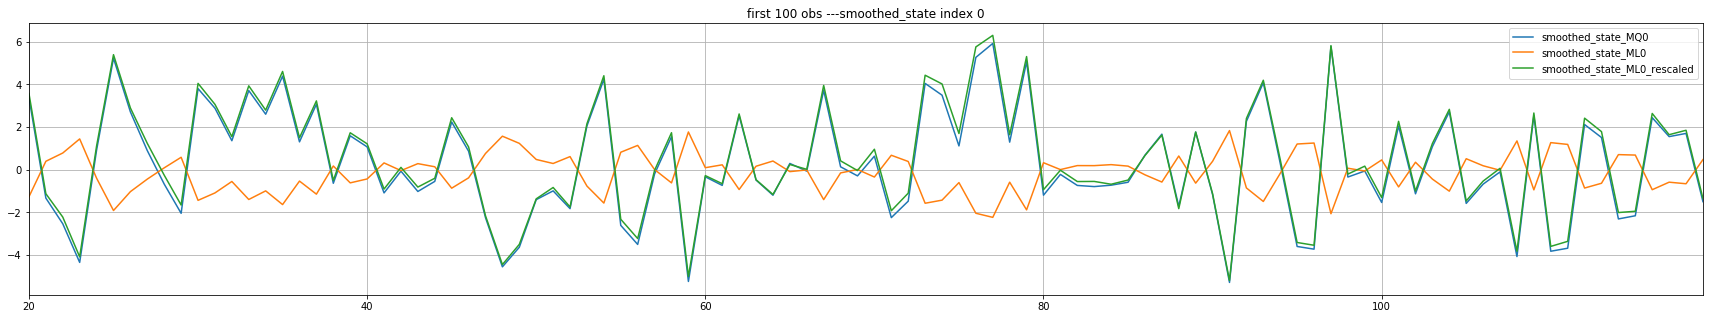

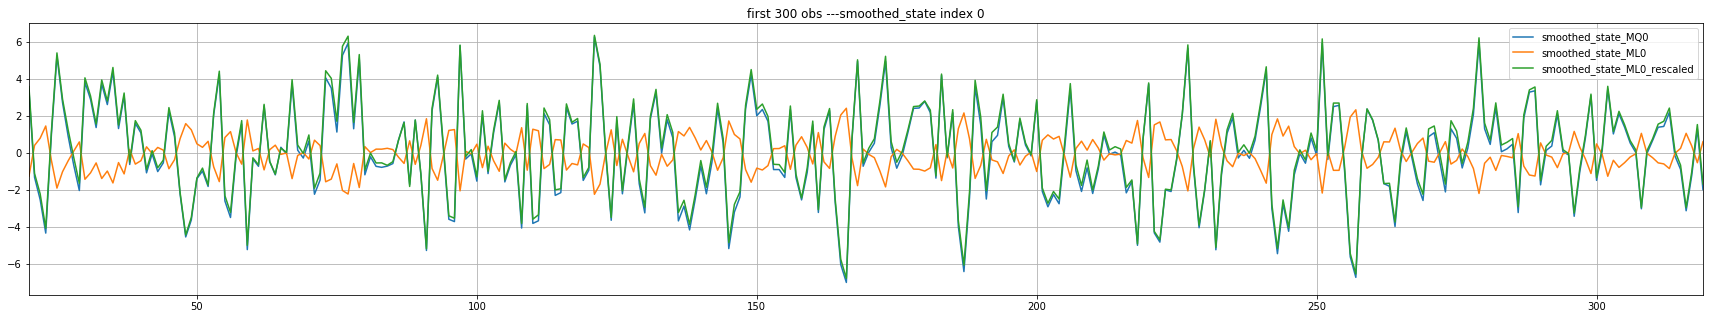

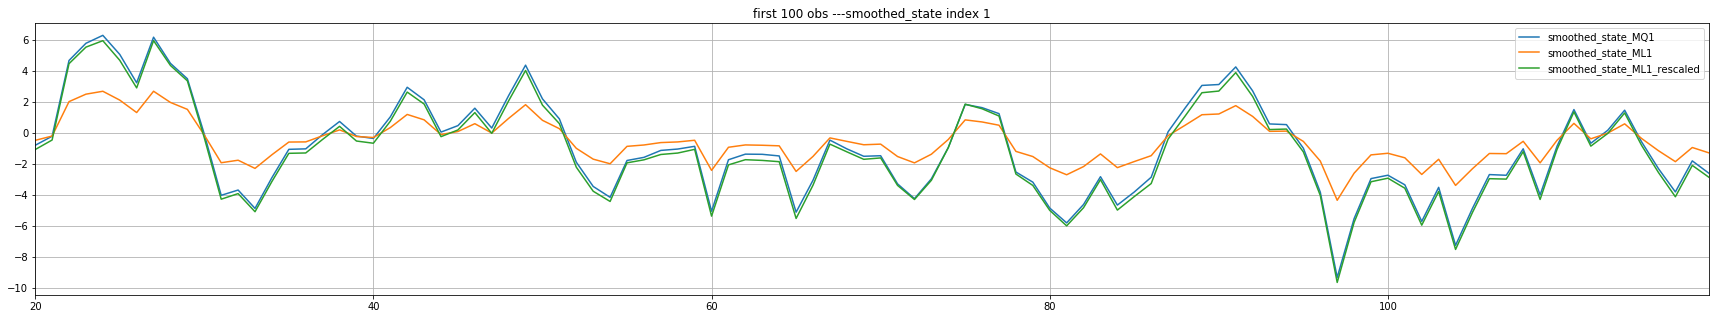

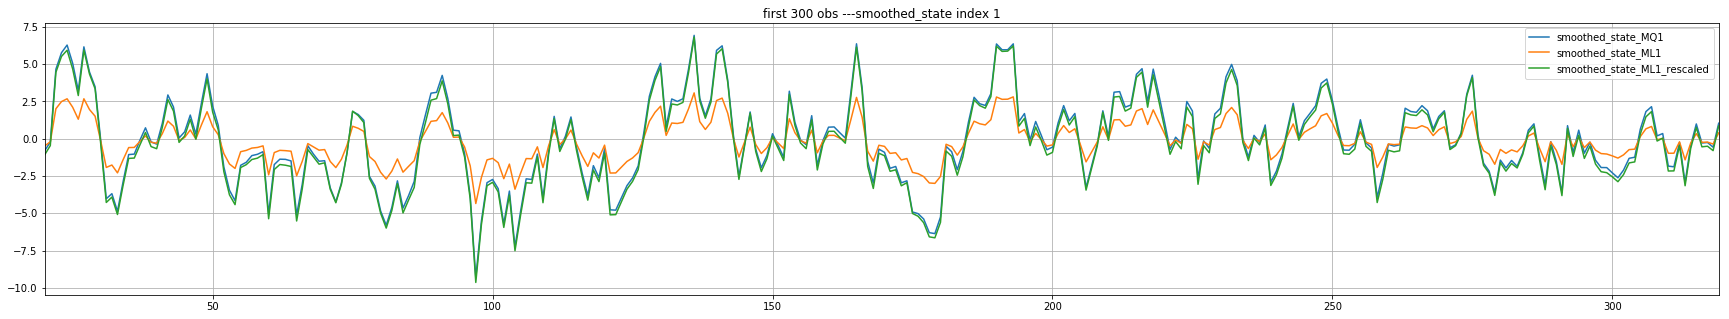

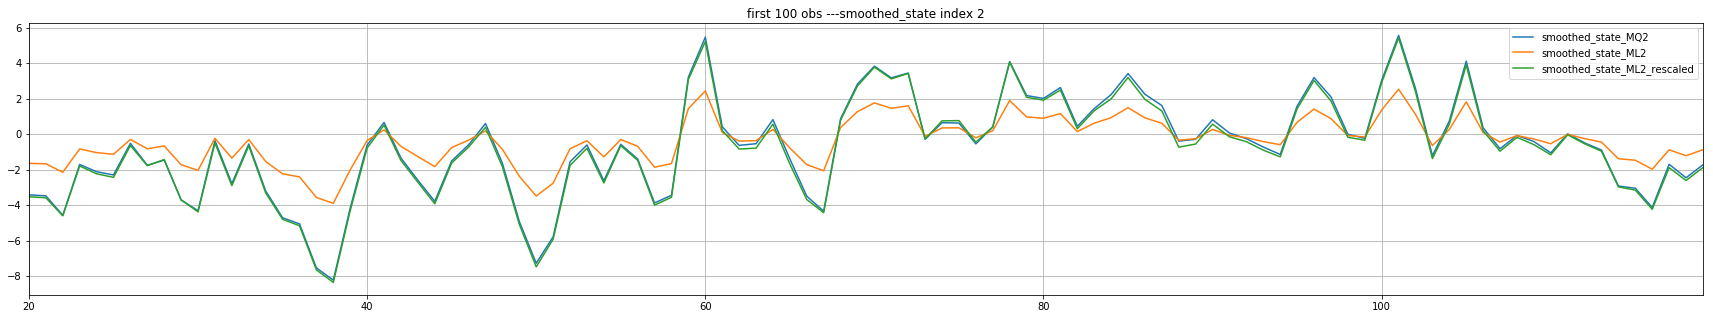

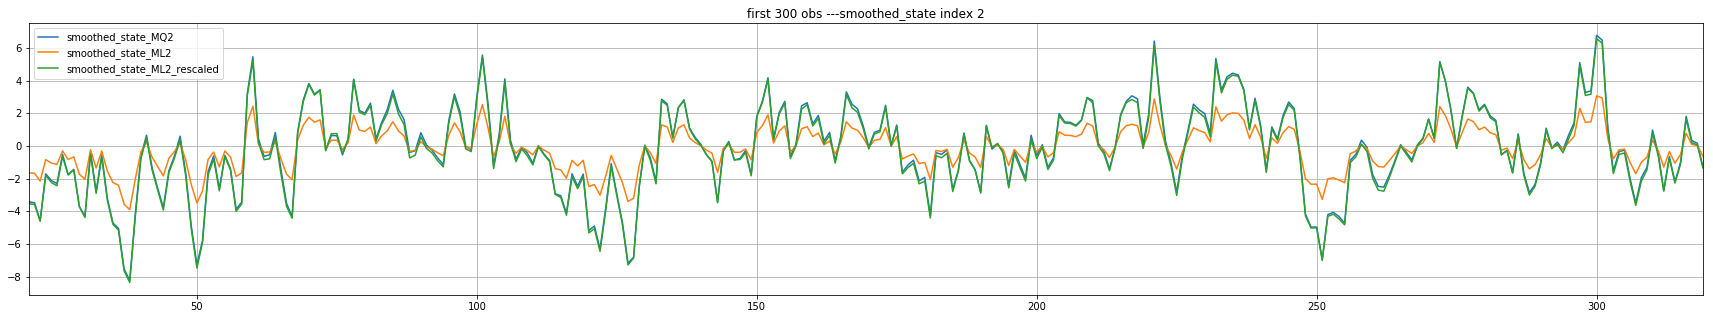

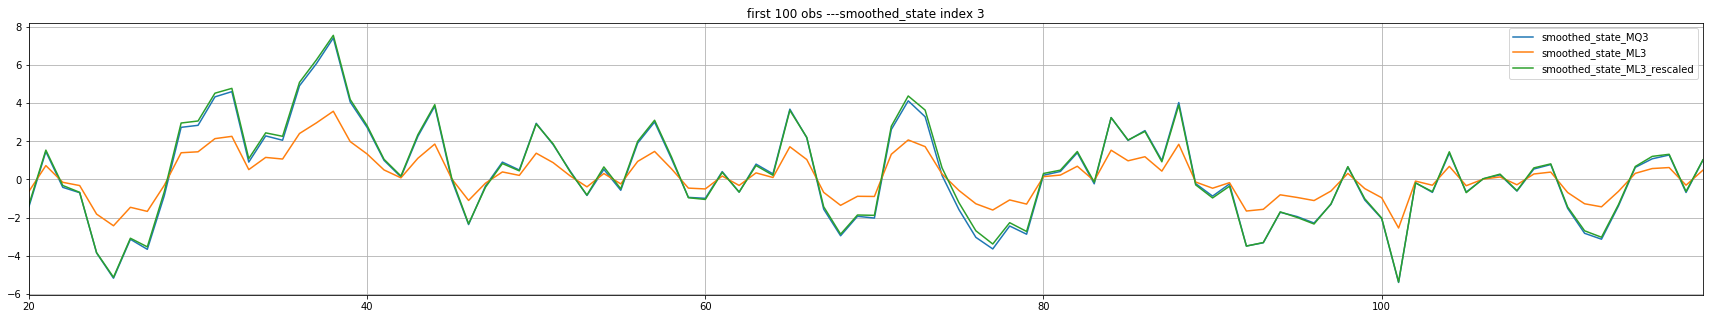

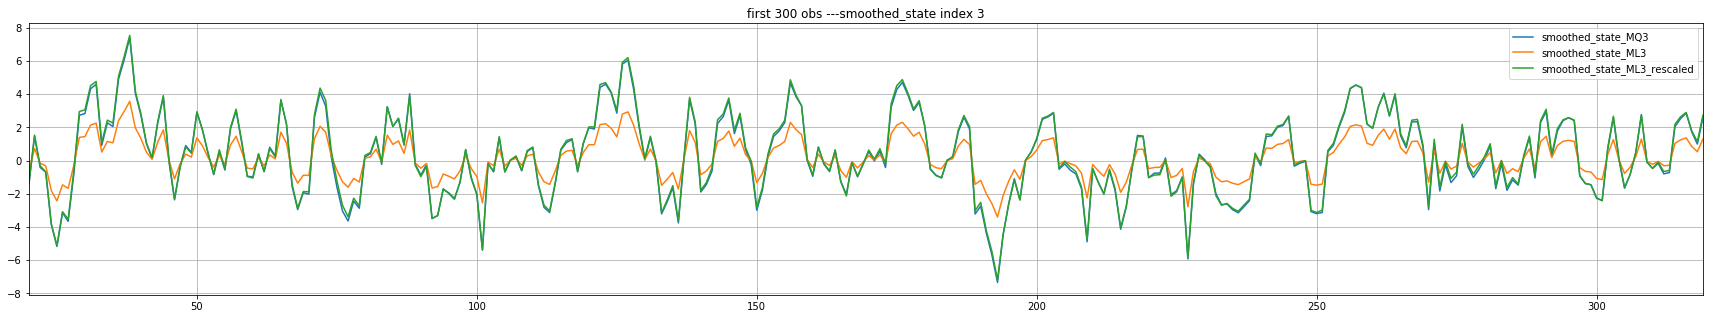

In [47]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

for i in range(results_ML.smoothed_state.shape[0]):

    str1='smoothed_state_MQ' + str(i)
    str2='smoothed_state_ML' + str(i)
    str3=str2+'_rescaled'
    mod = smf.ols(formula=str1 + '~' + str2, data=df_all)

    res = mod.fit()
    print('------> Adj. R-squared: ', res.rsquared_adj)
    print('------> Parameters: ', res.params)

    df_all[str3]=df_all[str2]*res.params[str2]
    df_all[[str1, str2, str3]][0:100].plot(figsize=(30, 5), grid=True,  title='first 100 obs ---smoothed_state index '+ str(i) )
    df_all[[str1, str2, str3]][0:300].plot(figsize=(30, 5), grid=True,  title='first 300 obs ---smoothed_state index '+ str(i) )